In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("shared/data/neighborhoods_boston.csv")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [6]:
df_description = pd.read_csv("shared/data/vars_boston.csv")
df_description.head()

,Unnamed: 0,Description
0,crim,Per capita crime rate by town.
1,zn,Proportion of residential land zoned for lots ...
2,indus,Proportion of non-retail business acres per town.
3,chas,Charles river dummy variable (= 1 if tract bou...
4,nox,Nitrogen oxides concentration (parts per 10 mi...


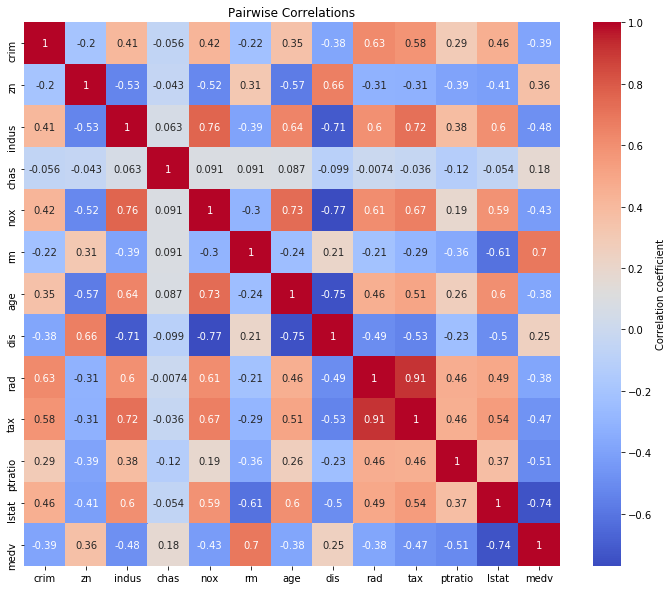

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2g", cmap="coolwarm", cbar_kws={'label': 'Correlation coefficient'})
plt.title('Pairwise Correlations')
plt.show()

Based on the descriptions of each variable, the directionality of the correlation between crime and distance to employment centers seemed counter-intuitive to me. These two variables are negatively correlated, with a coefficient of -0.38. This implies that as crime rate increases, distance to an employment center decreases. It seems more intuitive to believe that opposite, as proximity to an employment center would motivate one to get their life together rather than commit a crime. 

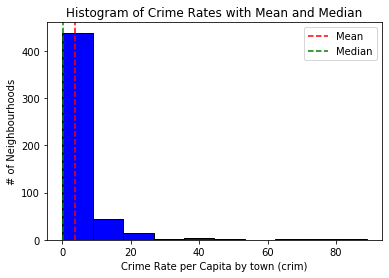

In [20]:
plt.hist(df['crim'], color='blue', edgecolor='black')
plt.axvline(x=df['crim'].mean(), color='red', linestyle = "dashed", label='Mean')
plt.axvline(x=df['crim'].median(), color='green', linestyle = "dashed", label='Median')
plt.title('Histogram of Crime Rates with Mean and Median')
plt.xlabel('Crime Rate per Capita by town (crim)')
plt.ylabel('# of Neighbourhoods')
plt.legend()
plt.show()

In [27]:
print(f"Median Crime Rate per Capita per Neighbourhood: {round(df['crim'].median(), 4)}")
print(f"Mean Crime Rate per Capita per Neighbourhood: {round(df['crim'].mean(), 4)}")

Median Crime Rate per Capita per Neighbourhood: 0.2565
Mean Crime Rate per Capita per Neighbourhood: 3.6135


The distribution in the plot above is pretty heavily right-skewed, which means that the mean value will be larger than the median. The median is 0.2565 meaning that 50% of neighbourhoods have a crime rate below this figure. The mean is 3.6135, and is pulled upwards by the few neighborhoods with extremely high "crim" values. Essentially, the skew of Crime rate per Capita says that the majority of towns are clustered to the left near the lower values, while a few extremely high-crime neighborhoods pull the mean crime rate up. 

Choosing the threshold of the median value over the mean is justified based on the fact that it represents the 50th percentile of data points, and is not affected by outliers. The median nicely splits the data into two halves, making it more useful as a threshold. 

In [33]:
crim_median = df['crim'].median()
df['crim_over_thresh'] = (df['crim'] >= crim_median).astype(int)
df[['crim', 'crim_over_thresh']].head()

,crim,crim_over_thresh
0,0.00632,0
1,0.02731,0
2,0.02729,0
3,0.03237,0
4,0.06905,0


In [39]:
from sklearn.model_selection import train_test_split
train, val_test = train_test_split(df, test_size=0.2, random_state=121224)
val, test = train_test_split(val_test, test_size=0.5, random_state=121224)

train_size = len(train)
val_size = len(val)
test_size = len(test)

train_size, val_size, test_size

(404, 51, 51)

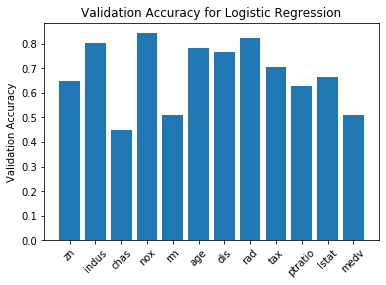

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

predictor_variables = [col for col in df.columns if col not in ['crim', 'crim_over_thresh']]
validation_accuracies = {}

for predictor in predictor_variables:
    # train and val data
    X_train = train[[predictor]]
    y_train = train['crim_over_thresh']
    X_val = val[[predictor]]
    y_val = val['crim_over_thresh']
    
    # logistic regression
    model = LogisticRegression(random_state=121224)
    model.fit(X_train, y_train)
    
    # Predict on val set, get accuracy
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies[predictor] = accuracy

plt.bar(validation_accuracies.keys(), validation_accuracies.values())
plt.xticks(rotation=45)
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Logistic Regression')
plt.show()

In [62]:
# Find the best performing model
best_predictor = max(validation_accuracies, key=validation_accuracies.get)
best_accuracy = validation_accuracies[best_predictor]

best_predictor, best_accuracy

('nox', 0.8431372549019608)

In [63]:
# Save the model
best_model = LogisticRegression(random_state=121224)
best_model.fit(train[[best_predictor]], train['crim_over_thresh'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=121224, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

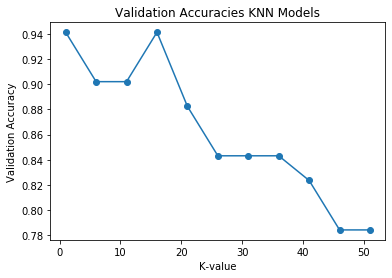

In [92]:
from sklearn.neighbors import KNeighborsClassifier

# k = 1, 6, 11, . . . , 51
k_values = list(range(1, 52, 5))
knn_accuracies = {}

# train and val data
X_train = train[[best_predictor]]
y_train = train['crim_over_thresh']
X_val = val[[best_predictor]]
y_val = val['crim_over_thresh']

# Train and evaluate KNN models for each k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    knn_accuracies[k] = accuracy

plt.plot(k_values, list(knn_accuracies.values()), marker='o')
plt.xlabel('K-value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies KNN Models')
plt.show()

In [87]:
# best k
best_k = max(knn_accuracies, key=knn_accuracies.get)
best_knn_accuracy = knn_accuracies[best_k]
best_k, best_knn_accuracy

(1, 0.9411764705882353)

In [88]:
# It says 1 is best K, but 16 looks to be similar, let's check
knn_accuracies[1], knn_accuracies[16]

(0.9411764705882353, 0.9411764705882353)

In [89]:
# since 1 and 16 have same accuracy, will choose 16 to avoid overfitting
best_k = 16
best_knn_accuracy = knn_accuracies[best_k]
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(X_train, y_train)

best_k, best_knn_accuracy

(16, 0.9411764705882353)

In [96]:
from sklearn.metrics import classification_report

X_test = test[[best_predictor]]
y_test = test['crim_over_thresh']

# logistic regression
logreg_predictions = best_model.predict(X_test)
logreg_report = classification_report(y_test, logreg_predictions)

# KNN
knn_predictions = best_knn_model.predict(X_test)
knn_report = classification_report(y_test, knn_predictions)

print("Logistic Regression Classification Report:\n", logreg_report)
print("\nKNN Classification Report:\n", knn_report)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79        24
           1       0.86      0.70      0.78        27

    accuracy                           0.78        51
   macro avg       0.79      0.79      0.78        51
weighted avg       0.80      0.78      0.78        51


KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       0.90      1.00      0.95        27

    accuracy                           0.94        51
   macro avg       0.95      0.94      0.94        51
weighted avg       0.95      0.94      0.94        51



KNN (k=16) is the better predictor here - 94% accuracy in f1-score, whereas the Logistic regression model only achieved 78%. the KNN model perform just as good or better in every single metric. 

In the context of the k-nearest neighbors algorithm, the model being a single-variable predictor means that it is designed to predict a single output variable. I believe that the main reason this algorithm makes an effective estimator of crim_over_thresh is because of the nature of the KNN algorithm. KNN works with identifying local patterns in a dataset, calculating from a given point to the rest. This computation can get heavy in high-dimensional spaces, but since we are only working with the "nox" independent variable it is optimized to do this. 